In [1]:
import torch
import numpy as np
from training import train
from data_utils import make_dataset, load_dataset
from controls import get_LQR
from tasks import stabilize_cartpole
from plotting import plot_trajectories
from models import save_model, load_model
import params

%load_ext autoreload
%autoreload 2

In [2]:
#data = make_dataset(save=True, fname=params.dataset, render_mode=None)
data = load_dataset(fname=params.dataset)
X, U, Xtest, Utest = data
X = torch.tensor(np.array(X)).float()
U = torch.tensor(np.array(U)).float()
Xtest = torch.tensor(np.array(Xtest)).float()
Utest = torch.tensor(np.array(Utest)).float()

In [3]:
# TRAIN MODEL #
#ae, fdyn, ae_opt, fdyn_opt = train(X, U, Xtest, Utest)
#ae, fdyn, ae_opt, fdyn_opt = train(X, U, Xtest, Utest, ae_0=(ae, ae_opt), fdyn_0=(fdyn, fdyn_opt))

# LOAD FROM CHECKPOINT #
ae, fdyn, ae_opt, fdyn_opt = load_model(fname=params.load_name)
#ae, fdyn, ae_opt, fdyn_opt = train(X, U, Xtest, Utest, ae_0=(ae, ae_opt), fdyn_0=(fdyn, fdyn_opt))

# SAVE # 
#save_model((ae, fdyn), (ae_opt, fdyn_opt), fname=params.save_name)                                  

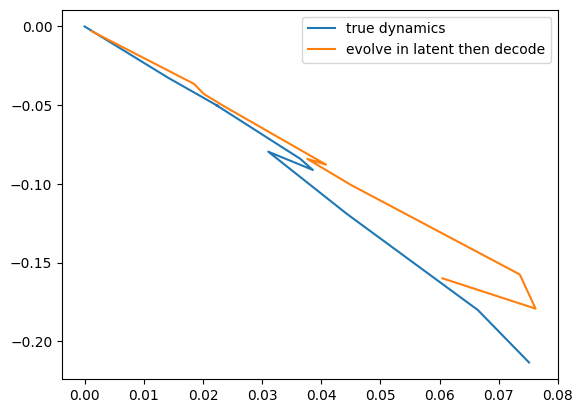

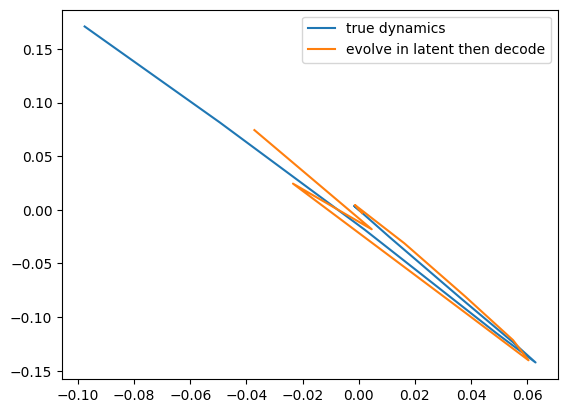

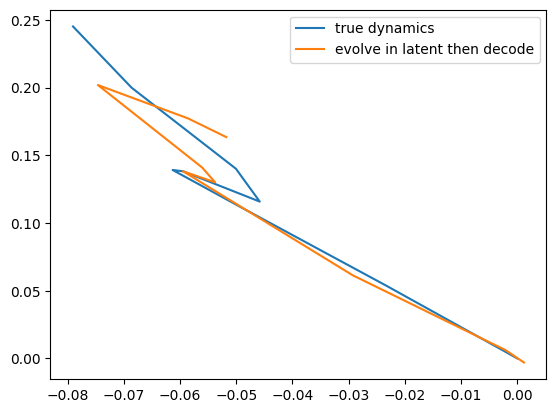

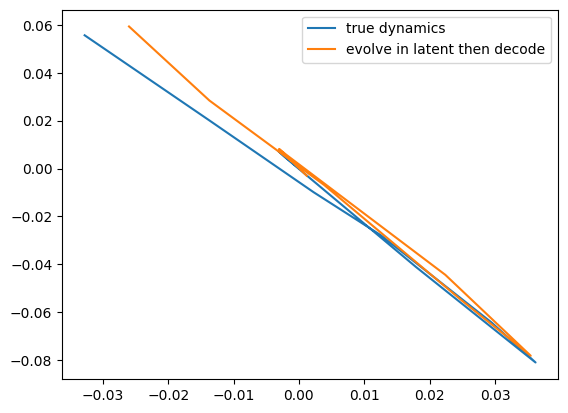

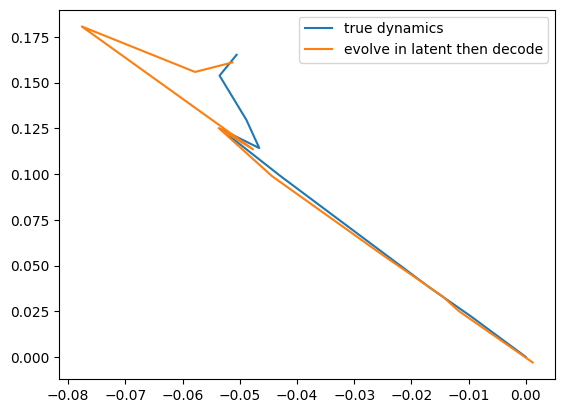

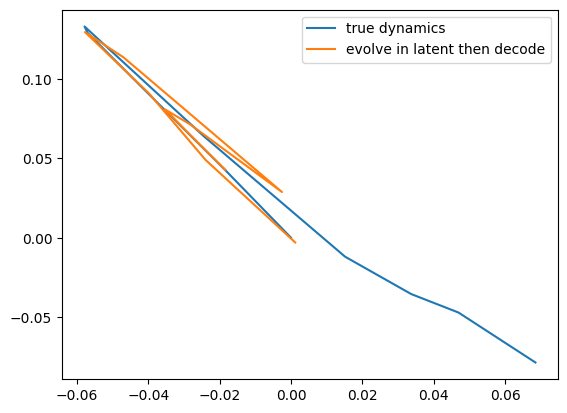

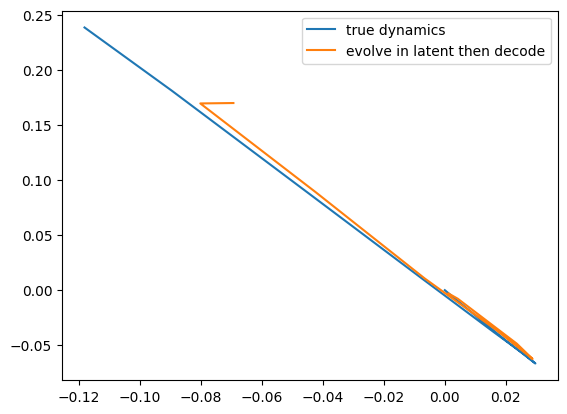

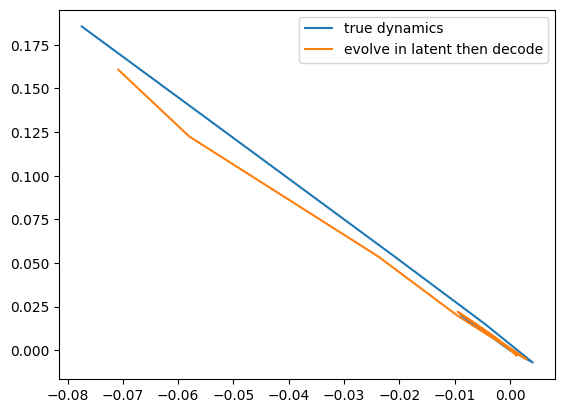

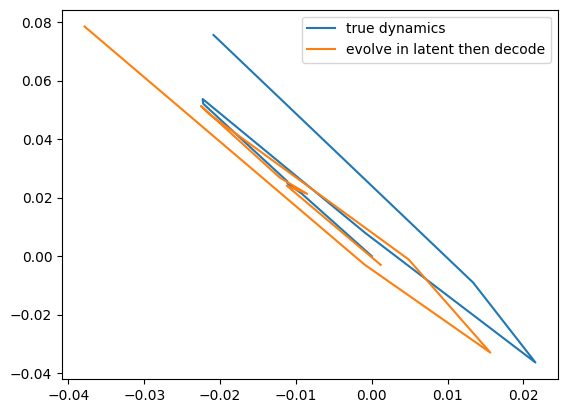

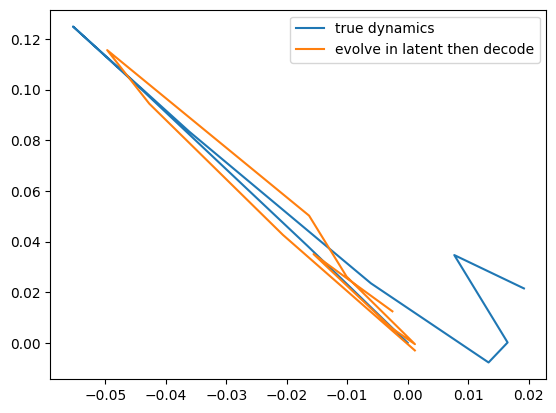

In [4]:
plot_trajectories(ae, fdyn, Xtest, Utest, 10)

In [5]:
from controls import LQR
#LQR = get_LQR(ae, fdyn)
lqr = LQR(ae, fdyn)
stabilize_cartpole(lqr, ae)

z_0 shape torch.Size([1, 2])
u_0 shape torch.Size([1, 1])
f_dyn input shape torch.Size([1, 3])
f_dyn output shape torch.Size([1, 2])
gradf[0] shape torch.Size([1, 2, 1, 2])
gradf[1] shape torch.Size([1, 2, 1, 1])
A shape torch.Size([2, 2])
B shape torch.Size([2, 1])
Q shape torch.Size([2, 2])
R shape torch.Size([1, 1])


/home/paul/miniconda3/envs/latent-space/lib/python3.12/site-packages/glfw/__init__.py:914: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


In [10]:
##########################
### LATENT LQR  BOUNDS ###
##########################

import sys
import os
#print(os.getcwd())
#sys.path.append(os.getcwd())# + '/auto_LiRPA/auto_LiRPA')
print(sys.path)

from collections import defaultdict
from auto_LiRPA import BoundedModule, BoundedTensor
from auto_LiRPA.perturbations import PerturbationLpNorm
from torchvision import transforms
import torch.nn as nn

z = torch.tensor([[0., 0.]])

class FeedbackDynamics(nn.Module):
    def __init__(self, dynamics, controller, component=0):
        super().__init__()
        self.dynamics = dynamics
        #for param in self.dynamics.parameters():
        #    param.requires_grad = False
        self.controller = controller
        self.component = component
        
    def forward(self, x):
        #print(self.controller(x).shape)
        #print(x.shape)
        x.requires_grad = False
        return self.dynamics( torch.cat((x[0], self.controller(x)[0])).unsqueeze(0))[0,self.component]
        
#lamb_1 = lambda z: fdyn( torch.cat((z, torch.unsqueeze(LQR(z), 0))) )[0]
#lamb_2 = lambda z: fdyn( torch.cat((z, torch.unsqueeze(LQR(z), 0))) )[1]
#fdyn_1 = nn.Sequential(transforms.Lambda(lamb_1))
#fdyn_2 = nn.Sequential(transforms.Lambda(lamb_2))
fdyn_1 = FeedbackDynamics(fdyn, lqr, component=0)
fdyn_2 = FeedbackDynamics(fdyn, lqr, component=1)


lirpa_fdyn_1 = BoundedModule(fdyn_1, torch.empty_like(z))
lirpa_fdyn_2 = BoundedModule(fdyn_2, torch.empty_like(z))

lower = torch.tensor([[-0.1, -0.1]])
upper = torch.tensor([[ 0.1,  0.1]])

norm = float("inf")
ptb = PerturbationLpNorm(norm=norm, x_L=lower, x_U=upper)
bounded_z = BoundedTensor(z, ptb)

lb1, ub1 = lirpa_fdyn_1.compute_bounds(x=(bounded_z,), method='IBP')
lb2, ub2 = lirpa_fdyn_2.compute_bounds(x=(bounded_z,), method='IBP')
print(lb1, ub1)
print(lb2, ub2)


['/home/paul/miniconda3/envs/latent-space/lib/python312.zip', '/home/paul/miniconda3/envs/latent-space/lib/python3.12', '/home/paul/miniconda3/envs/latent-space/lib/python3.12/lib-dynload', '', '/home/paul/miniconda3/envs/latent-space/lib/python3.12/site-packages', '/home/paul/Documents/cartpole_ae/auto_LiRPA', '/home/paul/miniconda3/envs/latent-space/lib/python3.12/site-packages/setuptools/_vendor']
tensor(-2.9993, grad_fn=<SqueezeBackward1>) tensor(3.3778, grad_fn=<SqueezeBackward1>)
tensor(-3.5208, grad_fn=<SqueezeBackward1>) tensor(3.9294, grad_fn=<SqueezeBackward1>)
